# Package loading and basic configurations

In [8]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
import pysal
pd.options.mode.chained_assignment = None 

from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
### Köln bbox coordinates
bbox = BboxSelector([
    6.756591796875, # min_x
    50.84583876895451, # min_y
    7.130126953125, # max_x
    51.06729071974382  # max_y
])

# issue a query
track_df = track_api.get_tracks(bbox=bbox, num_results=50) # requesting 50 tracks inside the bbox
track_df.head()

,id,time,geometry,GPS Speed.value,GPS Speed.unit,Rpm.value,Rpm.unit,Consumption.value,Consumption.unit,CO2.value,...,sensor.constructionYear,sensor.manufacturer,Intake Pressure.value,Intake Pressure.unit,O2 Lambda Voltage ER.value,O2 Lambda Voltage ER.unit,O2 Lambda Voltage.value,O2 Lambda Voltage.unit,Calculated MAF.value,Calculated MAF.unit
0,5ced331e44ea8503029199ba,2019-05-27T15:22:55,POINT (7.05132 51.05489),48.294837,km/h,1778.965422,u/min,3.412819,l/h,8.020125,...,2003,Volvo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5ced331e44ea8503029199bc,2019-05-27T15:23:00,POINT (7.05217 51.05517),48.728474,km/h,1827.263196,u/min,5.332561,l/h,12.531518,...,2003,Volvo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5ced331e44ea8503029199bd,2019-05-27T15:23:05,POINT (7.05317 51.05546),55.002977,km/h,2090.507247,u/min,8.826228,l/h,20.741636,...,2003,Volvo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5ced331e44ea8503029199be,2019-05-27T15:23:10,POINT (7.05425 51.05578),61.783353,km/h,1753.334310,u/min,5.029077,l/h,11.818331,...,2003,Volvo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5ced331e44ea8503029199bf,2019-05-27T15:23:15,POINT (7.05530 51.05608),60.628746,km/h,1752.000000,u/min,5.452218,l/h,12.812713,...,2003,Volvo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


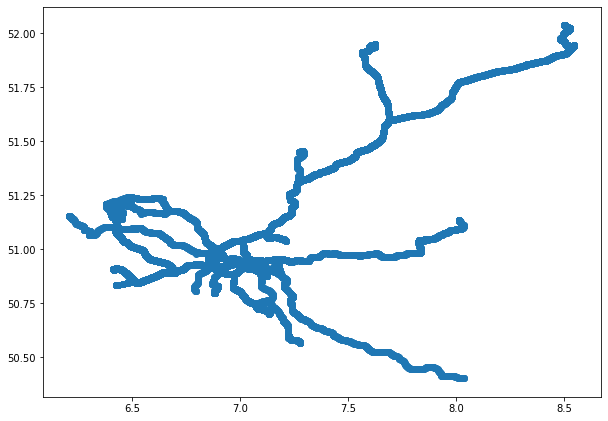

In [4]:
track_df.plot(figsize=(10, 12))

# Inspecting a single Track

In [14]:
from pysal import esda
import numpy as np

## select stopping times data
df_speed = track_df[track_df['GPS Speed.value'] == 0]
df_speed.crs  ### WGS84
df_speed['lat'] = df_speed['geometry'].apply(lambda coord: float(coord.y))
df_speed['lng'] = df_speed['geometry'].apply(lambda coord: float(coord.x))

##group by geometry
df_speed['geometry'] = df_speed['geometry'].to_crs('EPSG:25832') ### ETRS89 / UTM zone 32N 
df_speed['coordY'] = df_speed['geometry'].apply(lambda coord: round(coord.y,4))
df_speed['coordX'] = df_speed['geometry'].apply(lambda coord: round(coord.x,4))
df_speed['time_sec'] = 5
df_speed.reset_index()


data_speed = df_speed.groupby(['coordX','coordY','lat','lng'])[['time_sec']].sum().reset_index()
data_speed
data_speed.to_csv('D:\M.Sc. Gesopatial Tecnologies\Courses\SIW012 - Floating Car Project\Assignments\Assignment 1\envirocar-py\examples\data.csv')

In [15]:
data_speed['time_sec'].describe()

count    2216.000000
mean       19.020758
std        13.744279
min         5.000000
25%         5.000000
50%        25.000000
75%        25.000000
max       265.000000
Name: time_sec, dtype: float64

(array([3.78367120e-02, 3.12413219e-04, 1.38850319e-04, 5.20688698e-05,
        3.47125798e-05, 5.20688698e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.47125798e-05]),
 array([  5.,  31.,  57.,  83., 109., 135., 161., 187., 213., 239., 265.]),
 <a list of 10 Patch objects>)

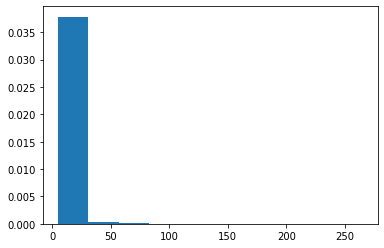

In [16]:
plt.hist(data_speed['time_sec'], density=True)

In [17]:
### calculate weights for getis ord
coords = [(row['coordY'], row['coordX']) for index, row in data_speed.iterrows()]
w = pysal.weights.DistanceBand(coords, threshold= 1)

C:\Anaconda\envs\python3\lib\site-packages\pysal\weights\weights.py:189: UserWarning: There are 183 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
C:\Anaconda\envs\python3\lib\site-packages\pysal\weights\weights.py:190: UserWarning: Island ids: 14, 24, 28, 29, 30, 31, 35, 36, 48, 60, 61, 62, 63, 64, 74, 80, 87, 88, 99, 100, 115, 116, 117, 118, 119, 120, 121, 122, 128, 137, 1062, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1162, 1208, 1209, 1210, 1213, 1214, 1215, 1216, 1230, 1250, 1251, 1259, 1262, 1263, 1267, 1273, 1295, 1296, 1297, 1303, 1304, 1305, 1306, 1307, 1319, 1339, 1357, 1361, 1369, 1388, 1403, 1407, 1421, 1422, 1431, 1432, 1433, 1434, 1435, 1436, 1453, 1454, 1455, 1456, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1522, 1525, 1533, 1536, 1539, 

In [18]:
#getisOrdGlobal = esda.getisord.G(data_speed['time_sec'], w)
getisOrdLocal = esda.getisord.G_Local(data_speed['time_sec'], w, transform='B')

C:\Anaconda\envs\python3\lib\site-packages\pysal\esda\getisord.py:434: RuntimeWarning: invalid value encountered in true_divide
  self.Zs = (self.Gs - self.EGs) / np.sqrt(self.VGs)
C:\Anaconda\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Anaconda\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Anaconda\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


In [19]:
getisOrdLocal.Zs

array([-2.6341751 , -1.95892713, -1.95892713, ...,         nan,
               nan,         nan])

In [20]:
data_speed['z_score'] = getisOrdLocal.Zs
data_speed['p_value'] = getisOrdLocal.p_norm

hotspots_speed = data_speed.query('p_value < 0.05')
hotspots_speed

,coordX,coordY,lat,lng,time_sec,z_score,p_value
0,304774.6901,5.670691e+06,51.154312,6.208303,5,-2.634175,0.004217
1,304774.6998,5.670691e+06,51.154313,6.208304,5,-1.958927,0.025061
2,304774.6998,5.670691e+06,51.154313,6.208304,5,-1.958927,0.025061
3,304774.6998,5.670691e+06,51.154313,6.208304,5,-1.958927,0.025061
4,304774.6998,5.670691e+06,51.154313,6.208304,5,-1.958927,0.025061
...,...,...,...,...,...,...,...
2201,431055.3167,5.665492e+06,51.136731,8.014547,5,-1.860957,0.031375
2202,431055.3262,5.665492e+06,51.136732,8.014547,10,-1.768377,0.038499
2203,431055.3262,5.665492e+06,51.136732,8.014547,5,-1.768905,0.038455
2204,431055.3357,5.665492e+06,51.136732,8.014547,5,-1.860957,0.031375


In [21]:
def pltcolor(p_value, z_score, confidence):
    cols=[]
    size=[]
    for p, z in zip(p_value, z_score):
        if p < confidence:
            if z > 0:
                cols.append('red')
                size.append(20)
            else:
                cols.append('blue')
                size.append(20)
        else:
            cols.append('grey')
            size.append(10)
    return cols , size

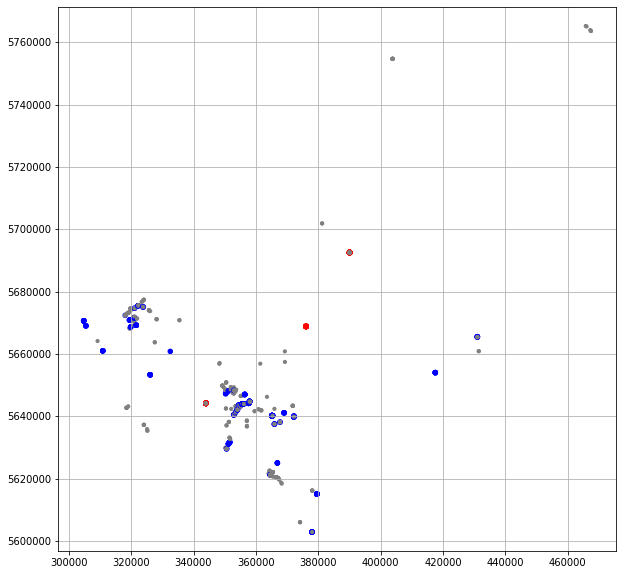

In [22]:
cols, sizes = pltcolor(data_speed['p_value'], data_speed['z_score'], 0.05)
f, axarr = plt.subplots(1, figsize=(10,10))
axarr.scatter(data_speed['coordX'], data_speed['coordY'], s = sizes, c= cols)
plt.axis('equal')
plt.grid(True)
plt.show()

In [23]:
import folium

lats = data_speed['lat']
lngs = data_speed['lng']
time = data_speed['time_sec']

#z-value
z = data_speed['z_score']
p = data_speed['p_value']

avg_lat = sum(lats) / len(lats)
avg_lngs = sum(lngs) / len(lngs)

m = folium.Map(location=[avg_lat - 0.25, avg_lngs], tiles = 'Stamen Terrain', zoom_start=9)

color, sizes = pltcolor(p, z, 0.05)


for lat,lng,c,s,t in zip(lats, lngs, color, sizes, time):
    radius = coords[2]
    folium.CircleMarker([lat,lng], color = c, radius = s/2, fill = c, popup = t).add_to(m)
m